# Introduction

In this notebook, we will create a dataset using four well-separated 2D Gaussians, each representing a different class, and use a neural network to classify these Gaussians. Let's begin with necessary imports.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data.dataset import Subset
from torch.optim import SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

# Creating the Dataset

Now let's build our dataset. We will have a total of $4000$ samples, with $1000$ samples per class. The distributions for each class will be centered at $(\pm 10, \pm 10)$ and will all have a variance of $(5, 5)$. we will use $10\%$ of our data for testing and the rest for training. We will also be using a batch size of $128$ and shuffle our train set for stochasticity in training. We don't need to shuffle our test set as we will always evaluate over the entire test set at once.

In [2]:
class_centers: list[list[int]] = [
    [10, 10],
    [10, -10],
    [-10, 10],
    [-10, -10]
]
variance: list[list[int]] = [
    [5, 0],
    [0, 5]
]
samples_per_class: int = 1000
X: np.ndarray = np.concatenate([
    np.random.multivariate_normal(
        mean=center,
        cov=variance,
        size=samples_per_class
    )
    for center in class_centers
])
Y: np.ndarray = np.concatenate([
    np.array([i] * samples_per_class) for i in range(len(class_centers))
])

Let's first take a look at our dataset.

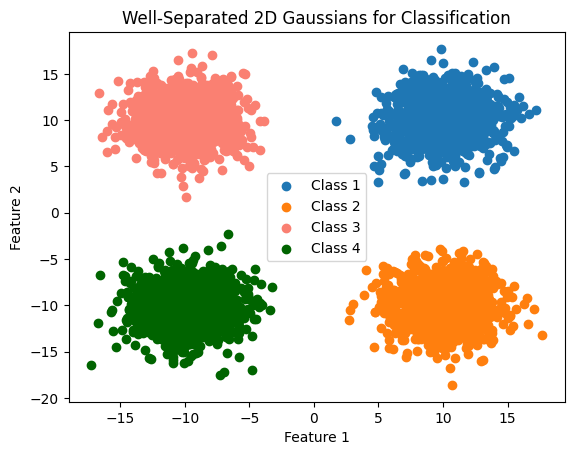

In [3]:
clss: int
colors: list[str] = ['tab:blue', 'tab:orange', 'salmon', 'darkgreen']
for clss in range(len(class_centers)):
    start: int = clss * samples_per_class
    end: int = (clss + 1) * samples_per_class
    plt.scatter(
        X[start:end, 0],
        X[start:end, 1],
        label=f"Class {clss + 1}",
        c=colors[clss]
    )
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Well-Separated 2D Gaussians for Classification")
plt.legend()
plt.show()

Now let's split it and put it into `Dataloader`s.

In [4]:
X_tensor: torch.Tensor = torch.from_numpy(X).to(torch.float32)
Y_tensor: torch.Tensor = torch.from_numpy(Y).to(torch.int64)

In [5]:
dataset: TensorDataset = TensorDataset(X_tensor, Y_tensor)
split_size: int = int(len(dataset) * 0.1)
train_set: Subset; test_set: Subset
train_set, test_set = random_split(
    dataset,
    [
        len(dataset) - split_size,
        split_size
    ]
)

In [6]:
train_dataloader: DataLoader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False
)

# Building the Classifier

Now let's build our classifier. Our classifier will take in a two-dimensional input, have one hidden layer with $8$ neurons and a ReLU activation, and output a log-softmaxed prediction across four classes. It will have a learning rate of $0.01$ and only needs to train for $20$ epochs using the ``torch.optim.SGD`` optimizer. The loss function will be `torch.nn.NLLLoss`, which, for a single training example $(x, y)$, is defined as $$\mathcal{L}(\theta) = \sum_{i=1}^C y_i\log f(x;\theta)_i$$ where $C$ is the number of classes and $f$ is our model parameterized by $\theta$.

In [7]:
class NN_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1: nn.Linear = nn.Linear(2, 8)
        self.linear2: nn.Linear = nn.Linear(8, 4)
        self.relu: nn.ReLU = nn.ReLU()
        self.log_softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [8]:
lr: float = 0.01
epochs: int = 20

model: NN_Classifier = NN_Classifier().cuda()
loss: nn.NLLLoss = nn.NLLLoss()
optimizer: SGD = SGD(model.parameters(), lr=lr)

Let's take a look at our model.

In [9]:
model

NN_Classifier(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
)

# Training the Model

Now let's train the model. Every batch, we will record the train and test loss. At the end of every epoch, we will also print out the average train loss over all batches in that epoch as well as the test loss and time elapsed.

In [10]:
metrics: list[str] = ['Train Loss', 'Test Loss']
history: pd.DataFrame = pd.DataFrame(columns=metrics)

for epoch in range(epochs):
    train_loss: float = 0.0
    test_loss: float = 0.0
    start_time: float = time()
    x: torch.Tensor; y: torch.Tensor
    print(f'Epoch {epoch + 1}')
    for _, (x, y) in enumerate(tqdm(train_dataloader)):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_pred: torch.Tensor = model(x)
        fit: torch.Tensor = loss(y_pred, y)
        fit.backward()
        optimizer.step()
        batch_train_loss = fit.item()
        train_loss += batch_train_loss
        for _, (x, y) in enumerate(test_dataloader):
            with torch.no_grad():
                x = x.cuda()
                y = y.cuda()
                y_pred = model(x)
                fit = loss(y_pred, y)
                test_loss += fit.item()
        test_loss /= len(test_dataloader)
        history.loc[len(history)] = [batch_train_loss, test_loss]
    time_elapsed: float = time() - start_time
    print(f'Epoch Average Train Loss: {train_loss}')
    print(f'Test Loss: {test_loss}')
    print(f'Time Elapsed: {time_elapsed:.2f}s')

Epoch 1


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 32.71it/s]


Epoch Average Train Loss: 34.776865631341934
Test Loss: 0.4256972335237697
Time Elapsed: 0.90s
Epoch 2


100%|██████████| 29/29 [00:00<00:00, 113.94it/s]


Epoch Average Train Loss: 5.143633000552654
Test Loss: 0.14922759037472033
Time Elapsed: 0.26s
Epoch 3


100%|██████████| 29/29 [00:00<00:00, 105.61it/s]


Epoch Average Train Loss: 2.2896968573331833
Test Loss: 0.08451634896717689
Time Elapsed: 0.28s
Epoch 4


100%|██████████| 29/29 [00:00<00:00, 90.57it/s]


Epoch Average Train Loss: 1.4071803987026215
Test Loss: 0.05806732834031627
Time Elapsed: 0.32s
Epoch 5


100%|██████████| 29/29 [00:00<00:00, 93.50it/s]


Epoch Average Train Loss: 1.013128288090229
Test Loss: 0.043961387177765904
Time Elapsed: 0.31s
Epoch 6


100%|██████████| 29/29 [00:00<00:00, 115.29it/s]


Epoch Average Train Loss: 0.7824675049632788
Test Loss: 0.03531193522991105
Time Elapsed: 0.25s
Epoch 7


100%|██████████| 29/29 [00:00<00:00, 118.84it/s]


Epoch Average Train Loss: 0.6376291047781706
Test Loss: 0.02946852662596734
Time Elapsed: 0.25s
Epoch 8


100%|██████████| 29/29 [00:00<00:00, 121.11it/s]


Epoch Average Train Loss: 0.5254524280317128
Test Loss: 0.025313265860762837
Time Elapsed: 0.24s
Epoch 9


100%|██████████| 29/29 [00:00<00:00, 115.77it/s]


Epoch Average Train Loss: 0.45466848090291023
Test Loss: 0.022211921282644126
Time Elapsed: 0.25s
Epoch 10


100%|██████████| 29/29 [00:00<00:00, 118.68it/s]


Epoch Average Train Loss: 0.4068225109949708
Test Loss: 0.019774523476449996
Time Elapsed: 0.25s
Epoch 11


100%|██████████| 29/29 [00:00<00:00, 117.66it/s]


Epoch Average Train Loss: 0.3654131758958101
Test Loss: 0.017809741522490145
Time Elapsed: 0.25s
Epoch 12


100%|██████████| 29/29 [00:00<00:00, 118.51it/s]


Epoch Average Train Loss: 0.3225372163578868
Test Loss: 0.01621859984028954
Time Elapsed: 0.25s
Epoch 13


100%|██████████| 29/29 [00:00<00:00, 101.91it/s]


Epoch Average Train Loss: 0.29339240537956357
Test Loss: 0.014898271724623841
Time Elapsed: 0.29s
Epoch 14


100%|██████████| 29/29 [00:00<00:00, 104.68it/s]


Epoch Average Train Loss: 0.2690853690728545
Test Loss: 0.01379138346342768
Time Elapsed: 0.28s
Epoch 15


100%|██████████| 29/29 [00:00<00:00, 112.18it/s]


Epoch Average Train Loss: 0.251127362716943
Test Loss: 0.012822653394123753
Time Elapsed: 0.26s
Epoch 16


100%|██████████| 29/29 [00:00<00:00, 101.12it/s]


Epoch Average Train Loss: 0.23189421137794852
Test Loss: 0.01199594073817688
Time Elapsed: 0.29s
Epoch 17


100%|██████████| 29/29 [00:00<00:00, 98.91it/s] 


Epoch Average Train Loss: 0.2144176848232746
Test Loss: 0.011277784402296787
Time Elapsed: 0.30s
Epoch 18


100%|██████████| 29/29 [00:00<00:00, 100.67it/s]


Epoch Average Train Loss: 0.20052283024415374
Test Loss: 0.01064470327279014
Time Elapsed: 0.29s
Epoch 19


100%|██████████| 29/29 [00:00<00:00, 117.07it/s]


Epoch Average Train Loss: 0.19029158540070057
Test Loss: 0.010077181440329337
Time Elapsed: 0.25s
Epoch 20


100%|██████████| 29/29 [00:00<00:00, 94.61it/s] 

Epoch Average Train Loss: 0.1795256498735398
Test Loss: 0.009569452473929391
Time Elapsed: 0.31s


# Analyzing the Model

Let's plot the train and test loss curves.

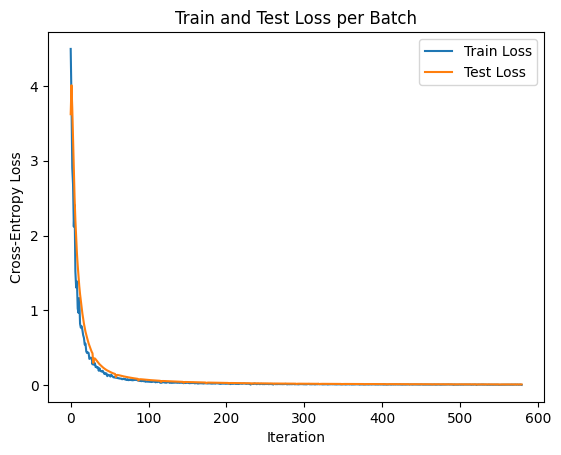

In [11]:
plt.plot(history.index, history['Train Loss'], label="Train Loss")
plt.plot(history.index, history['Test Loss'], label="Test Loss")
plt.title("Train and Test Loss per Batch")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.show()

The train error seems to drop quickly and consistently before evening out, and the test error drops along with it. This makes sense as the dataset was remarkably simple, and the batch size was large enough to where the gradient steps were stable.

Now let's take a look at our final train and test accuracies.

In [12]:
def compute_accuracy(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Computes the accuracy of the model over every training example in
    the DataLoader.

    Parameters:
        model:      The model to be evaluated over the DataLoader
        dataloader: The DataLoader over which the model is to be evaluated
    """
    x: torch.Tensor; y: torch.Tensor
    correct_predictions: int = 0
    with torch.no_grad():
        for _, (x, y) in enumerate(tqdm(dataloader)):
            x = x.cuda()
            y = y.cuda()
            out: torch.Tensor = model(x)
            y_pred: torch.Tensor
            _, y_pred = torch.max(out, dim=1)
            correct_predictions += (y_pred == y).sum().item()
    return correct_predictions * 100 / len(dataloader.dataset)

In [15]:
train_accuracy: float = compute_accuracy(model, train_dataloader)
test_accuracy: float = compute_accuracy(model, test_dataloader)
print(
    f"Final Train Accuracy: {train_accuracy:.2f}%,",
    f"Final Test Accuracy: {test_accuracy:.2f}%"
)

100%|██████████| 4/4 [00:00<00:00, 444.50it/s]

Final Train Accuracy: 100.00%, Final Test Accuracy: 100.00%


We've achieved $100\%$ accuracy on both the train and test set, which makes sense, as the dataset was exceptionally simple.